In [1]:
import deepchem as dc
import pandas as pd
import numpy as np
from rdkit import Chem

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,KFold

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
data = pd.read_csv('../../data/GABAA.csv',encoding='gb18030')

# Feature extraction & Data splitting

In [3]:
featurizer = dc.feat.RDKitDescriptors()
features = featurizer.featurize(data['smiles'])
#dataset = dc.data.NumpyDataset(features,data['class'])

In [4]:
from sklearn.feature_selection import VarianceThreshold


vt = VarianceThreshold(threshold = (.98 * (1 - .98)))


X_new = vt.fit_transform(features)
dataset = dc.data.NumpyDataset(X_new,data['class'])

In [7]:
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=300)

# GridSearchCV

In [9]:
scoring = {
         'AUC':make_scorer(roc_auc_score, needs_proba=True),
          'ACC':make_scorer(accuracy_score),
           'PRE':make_scorer(precision_score),
           'REC':make_scorer(recall_score),
            
}

classifier  =  RandomForestClassifier(random_state=242)

rf_param_grid = {'n_estimators':[80,100,120,140,160,180,200,220,240,260],
              'max_depth':[5,8,10,20,30,40],
            'max_features':["auto", "sqrt", "log2"]}
    

rf_gs = GridSearchCV(
                    classifier,
                   rf_param_grid,
                 scoring = scoring,
                  cv = KFold(n_splits=5, shuffle=True, random_state=300),
                 n_jobs = -1,
               refit = 'AUC',
               return_train_score = True)

rf_gs_fit = rf_gs.fit(train_dataset.X, train_dataset.y.ravel())

In [10]:
val_AUC = rf_gs.best_score_
val_ACC = rf_gs.cv_results_['mean_test_ACC'][rf_gs.best_index_]
val_PRE = rf_gs.cv_results_['mean_test_PRE'][rf_gs.best_index_]
val_REC = rf_gs.cv_results_['mean_test_REC'][rf_gs.best_index_]

# GridSearchCV_Result

In [11]:
print('Best parameters: ', rf_gs.best_params_)
print('Best score (AUC): ', rf_gs.best_score_)
print('ACC: ', rf_gs.cv_results_['mean_test_ACC'][rf_gs.best_index_])
print('PRE: ', rf_gs.cv_results_['mean_test_PRE'][rf_gs.best_index_])
print('REC: ',rf_gs.cv_results_['mean_test_REC'][rf_gs.best_index_])

Best parameters:  {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 180}
Best score (AUC):  0.9365620740249401
ACC:  0.8717948717948717
PRE:  0.8596783943856557
REC:  0.8860763744867173


In [12]:
rf_model = rf_gs_fit.best_estimator_
rf_model

RandomForestClassifier(max_depth=20, n_estimators=180, random_state=242)

# Evaluate model

In [13]:
y_test_pred_proba = rf_model.predict_proba(test_dataset.X)
y_test_pred = rf_model.predict(test_dataset.X)

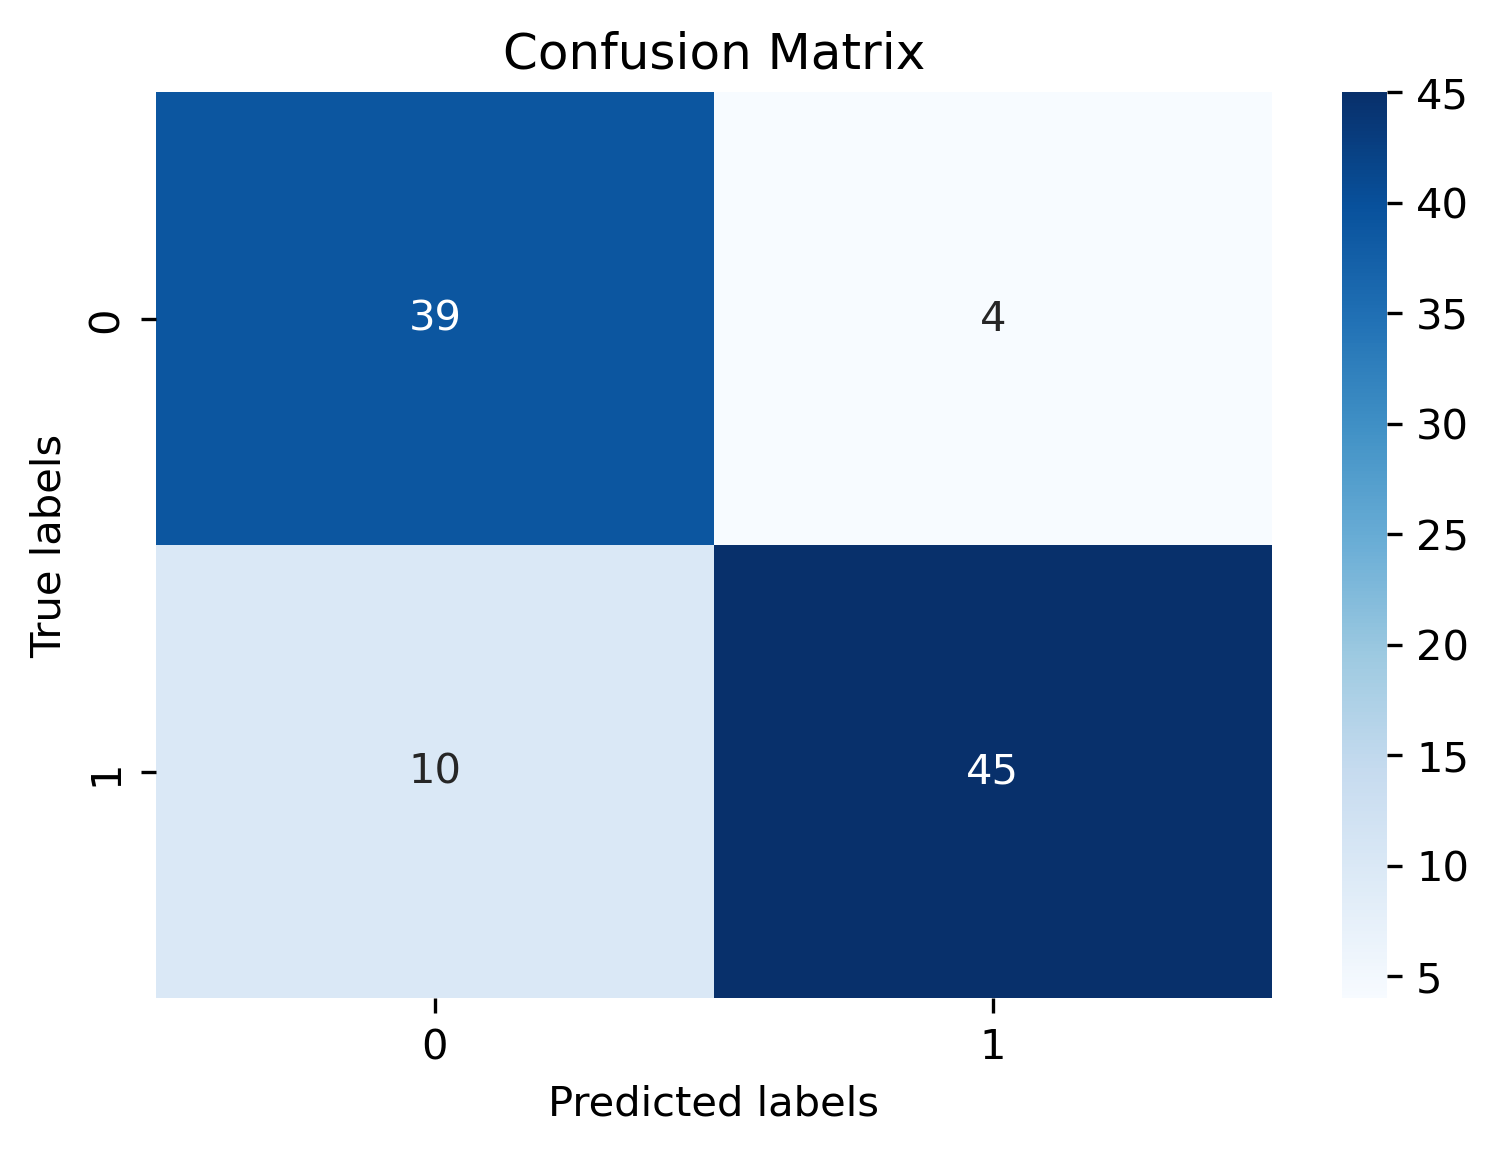

In [15]:
confusion_mat = confusion_matrix(test_dataset.y, y_test_pred)
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [16]:
rf_test_pred_list = []
for test_score in y_test_pred_proba:
    test_score = test_score[1]
    rf_test_pred_list.append(test_score)

In [17]:
rf_test_pred_array = np.array(rf_test_pred_list)

In [18]:
test_AUC = roc_auc_score(test_dataset.y,rf_test_pred_list)
test_ACC = accuracy_score(test_dataset.y,np.round(rf_test_pred_array))
test_PRE = precision_score(test_dataset.y,np.round(rf_test_pred_array))
test_REC = recall_score(test_dataset.y,np.round(rf_test_pred_array))

# Finall result

In [19]:
rf_performance_dataset = {
    'AUC':[val_AUC,test_AUC],
    'ACC':[val_ACC,test_ACC],
    'PRE':[val_PRE,test_PRE],
    'REC':[val_REC,test_REC]
}

In [20]:
rf_performance = pd.DataFrame(rf_performance_dataset,index=['val','test'])
rf_performance

,AUC,ACC,PRE,REC
val,0.936562,0.871795,0.859678,0.886076
test,0.961522,0.857143,0.918367,0.818182
